# Ozone forcing


Skeie et al. 2021:

- time series of all depleters, warming included

Fit coefficients to reproduce the temperatures.

In [1]:
from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
import pooch
from scipy.interpolate import interp1d
from scipy.optimize import root

In [2]:
st_df = pd.read_csv('../data/skeie2020/skeie_ozone_strat.csv', index_col="Model")
tr_df = pd.read_csv('../data/skeie2020/skeie_ozone_trop.csv', index_col="Model")

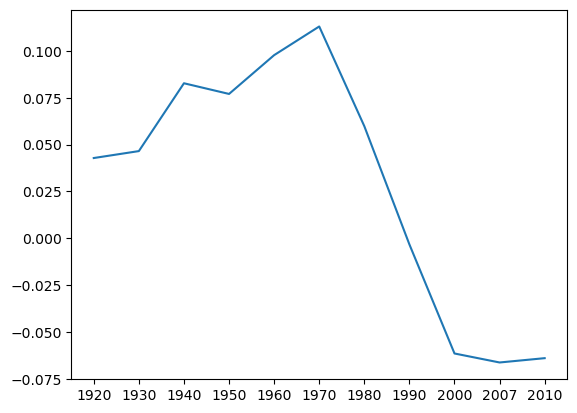

In [3]:
# Skeie uses 10 year averages: 1920 is 1916-1925 up to 2000. 2007 is 2003-2012. 2010 is 2005-2014.
o3_ukesm = st_df.loc['UKESM1-0-LL'] + tr_df.loc['UKESM1-0-LL']
pl.plot(o3_ukesm)

In [4]:
temp_ukesm = np.ones((165, 19)) * np.nan
for run in range(19):
    try:
        temp_ukesm[:, run] = pd.read_csv('../data/fredriksen2022/historical/UKESM1-0-LL_historical_r%di1p1f2_anomalies.txt' %(run+1), index_col=0)['tas'].values
    except FileNotFoundError:
        pass

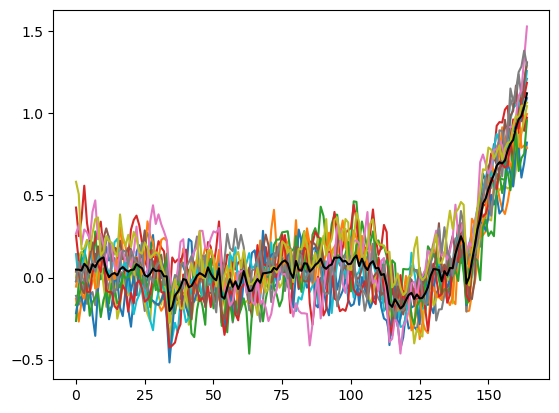

In [5]:
pl.plot(temp_ukesm);
temp_ukesm_mean = np.nanmean(temp_ukesm, axis=1)
pl.plot(temp_ukesm_mean, color='k')

In [6]:
interpolator = interp1d(o3_ukesm.index.map(float), o3_ukesm)

In [7]:
ukesm_o3_forcing_1920_2010 = interpolator(np.arange(1920, 2011))

In [8]:
climate_response_df = pd.read_csv('../data/fair-calibrations/4xCO2_energy_balance_ebm3.csv')

In [9]:
natural_forcing_df = pd.read_csv('../data/calibration/natural_forcing.csv', index_col=0)

In [10]:
def erf_rootfinder(x):
    n2o_scale = x[0]
    voc_scale = x[1]
    nox_scale = x[2]
    eesc_scale = x[3]
    t_fb = x[4]
    f = FAIR(temperature_prescribed=True)
    scenarios = ['ssp245']
    configs = ['UKESM1-0-LL']
    species, properties = read_properties()
    species.remove('CO2 FFI')      # c-driven run
    species.remove('CO2 AFOLU')    # c-driven run
    species.remove('Halon-1202')   # not in CMIP6 list of species
    species.remove('Contrails')    # not modelled in UKESM, I think
    species.remove('NOx aviation') # which renders this redundant
    species.remove('Light absorbing particles on snow and ice')  # I believe not modelled in UKESM
    del properties['CO2 FFI']
    del properties['CO2 AFOLU']
    del properties['Halon-1202']
    del properties['Contrails']
    del properties['NOx aviation']
    del properties['Light absorbing particles on snow and ice']
    for specie in species:
        if properties[specie]['greenhouse_gas']:
            properties[specie]['input_mode'] = 'concentration'
    properties['Land use']['input_mode'] = 'forcing'
    f.define_time(1850, 2015, 1)
    f.define_scenarios(scenarios)
    f.define_configs(configs)
    f.define_species(species, properties)
    f.allocate()
    fill(f.climate_configs['ocean_heat_capacity'], climate_response_df.loc[0, 'C1':'C3'])
    fill(f.climate_configs['ocean_heat_transfer'], climate_response_df.loc[0, 'kappa1':'kappa3'])
    fill(f.climate_configs['deep_ocean_efficacy'], climate_response_df.loc[0, 'epsilon'])
    fill(f.climate_configs['gamma_autocorrelation'], climate_response_df.loc[0, 'gamma'])
    initialise(f.forcing, 0)
    initialise(f.temperature, 0)
    f.fill_species_configs()
    f.fill_from_rcmip()
    # override RCMIP natural forcing
    fill(f.forcing, natural_forcing_df.loc[1850:2015, 'solar'][:, None, None], specie='Solar')
    fill(f.forcing, natural_forcing_df.loc[1850:2015, 'volcanic'][:, None, None], specie='Volcanic')
    landuse_erf = pd.read_csv('../data/calibration/landuse_forcing.csv', index_col=0)
    f.forcing.loc[dict(specie='Land use')] = landuse_erf.values[:, None]
    # 1850 baselines
    for specie in ['Sulfur', 'BC', 'OC', 'NOx', 'VOC', 'CO', 'NH3']:
        f.species_configs['baseline_emissions'].loc[dict(specie=specie)] = f.emissions.loc[dict(specie=specie, timepoints=1850.5, scenario='ssp245')]

    for specie in ['CO2', 'CH4', 'N2O', 'CFC-11', 'CFC-12', 'CFC-113', 'CFC-114', 'CFC-115', 'HCFC-22', 'HCFC-141b', 'HCFC-142b',
        'CCl4', 'CHCl3', 'CH2Cl2', 'CH3Cl', 'CH3CCl3', 'CH3Br', 'Halon-1211', 'Halon-1301', 'Halon-2402',
        'CF4', 'C2F6', 'C3F8', 'c-C4F8', 'C4F10', 'C5F12', 'C6F14', 'C7F16', 'C8F18', 'NF3', 'SF6', 'SO2F2',
        'HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
        'HFC-32', 'HFC-365mfc', 'HFC-4310mee']:
        f.species_configs['baseline_concentration'].loc[dict(specie=specie)] = f.concentration.loc[dict(specie=specie, timebounds=1850, scenario='ssp245')]

    f.species_configs['baseline_concentration'].loc[dict(specie='Equivalent effective stratospheric chlorine')] = 0

    ## rebase volcanic to zero mean
    #f.forcing.loc[dict(specie='Volcanic')] = f.forcing.loc[dict(specie='Volcanic')] - f.forcing.loc[dict(specie='Volcanic', scenario='ssp245', config='UKESM1-0-LL')].mean()
    
    ch4 = f.concentration.loc[dict(specie='CH4')].squeeze().values
    n2o = f.concentration.loc[dict(specie='N2O')].squeeze().values
    eesc = f.concentration.loc[dict(specie='Equivalent effective stratospheric chlorine')].squeeze().values

    voc = f.emissions.loc[dict(specie='VOC')].squeeze().values
    co = f.emissions.loc[dict(specie='CO')].squeeze().values
    nox = f.emissions.loc[dict(specie='NOx')].squeeze().values
    
    # values from Thornhill
    n2o_eff = 0.04 / (n2o[164]-n2o[0])
    voc_eff = 0.11 / (voc[164]-voc[0])
    nox_eff = 0.14 / (nox[164]-nox[0])
    eesc_eff = -0.33 / (1.13324964e+03)  # precalc
    n2o_eff, voc_eff, nox_eff, eesc_eff
    
    # fill temperature
    f.temperature[:-1, ...] = temp_ukesm_mean[:, None, None, None]
    f.temperature[-1, ...] = f.temperature[-2, ...]

    # pre-calibrated for aerosol and CH4 runs: do not adjust
    f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='Sulfur')] = -0.00447635
    f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='BC')] = 0.05297455
    f.species_configs['erfari_radiative_efficiency'].loc[dict(specie='OC')] = -0.00781294
    f.species_configs['aci_scale'].loc[dict(config='UKESM1-0-LL')] = -0.63667782
    f.species_configs['aci_shape'].loc[dict(specie='Sulfur')] = 0.03110931
    f.species_configs['aci_shape'].loc[dict(specie='BC')] = 0.00221948
    f.species_configs['aci_shape'].loc[dict(specie='OC')] = 0.00864984
    f.species_configs['forcing_scale'].loc[dict(specie="CH4")] = 1.11547955
    f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="CH4")] = 1.27049657e-04
    f.species_configs['h2o_stratospheric_factor'].loc[dict(specie="CH4")] = 1.29652705e-01
    f.species_configs['erfari_radiative_efficiency'].loc[dict(specie="CH4")] = -5.09377882e-05
    f.species_configs['aci_shape'].loc[dict(specie="CH4")] = -3.54174562e-04

    f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="Equivalent effective stratospheric chlorine")] = eesc_eff
    f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="N2O")] = n2o_eff
    f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="VOC")] = voc_eff
    f.species_configs['ozone_radiative_efficiency'].loc[dict(specie="NOx")] = nox_eff
    f.species_configs['forcing_temperature_feedback'].loc[dict(specie="Ozone")] = t_fb  # Thornhill et al 2021 feedbacks
    
    f.run(progress=False)
    return (
        f.forcing.loc[dict(specie='Ozone', scenario='ssp245', config='UKESM1-0-LL', timebounds=slice(1920, 2010))].data -
        ukesm_o3_forcing_1920_2010
    )

In [11]:
sol = root(
    erf_rootfinder, 
    np.array(
        [
            0.0007481397748679878,
            0.0006596999582126578,
            0.000984642055228785,
            -0.00029119797470220245,
            -0.079
        ],
    ),
    method='lm',
    options={'maxiter': 500000}
)

/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_90195/2755678584.py:41: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  fill(f.forcing, natural_forcing_df.loc[1850:2015, 'solar'][:, None, None], specie='Solar')
/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_90195/2755678584.py:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  fill(f.forcing, natural_forcing_df.loc[1850:2015, 'volcanic'][:, None, None], specie='Volcanic')
/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_90195/2755678584.py:41: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  fill(f.forc

/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_90195/2755678584.py:41: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  fill(f.forcing, natural_forcing_df.loc[1850:2015, 'solar'][:, None, None], specie='Solar')
/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_90195/2755678584.py:42: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  fill(f.forcing, natural_forcing_df.loc[1850:2015, 'volcanic'][:, None, None], specie='Volcanic')
/var/folders/6q/3d6ldw_97jq9lq39ckxj292c0000gn/T/ipykernel_90195/2755678584.py:41: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  fill(f.forc

In [12]:
sol.x[0], sol.x[1], sol.x[2], sol.x[3], sol.x[4]

(0.0007481397748679878,
 0.0006596999582126578,
 0.000984642055228785,
 -0.00029119797470220245,
 -0.22269985358559521)